# Import Python libraries to be used

In [370]:
import pandas as pd
import pypsa
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Define any custom python functions

In [371]:
# Calculate the capital recovery factor for annualised cost calculations
def annuity(lifetime, rate):
    if rate == 0.:
        return 1/lifetime
    else:
        return rate/(1. - 1. / (1. + rate)**lifetime)
    
def remove_leap_day(df):
    return df[~((df.month == 2) & (df.day == 29))]

# Read in any hourly profiles that will be used in the model

In [372]:
wind = xr.open_dataarray("extendable_wind_era5_10.nc")
solar_pv = xr.open_dataarray("extendable_solar_pv_sarah_10.nc")

In [373]:
#wind_profiles = pd.read_csv('SWA_wind.csv', index_col=0, parse_dates=True).resample('1h').mean()
# pv_profiles = pd.read_csv('SWA_solar_pv.csv', index_col=0,parse_dates=True).resample('1h').mean()

In [374]:
wind_pu = wind.sel(time="2017", bus="Western Cape", intra_region="redz_corridors_eia").to_pandas()
solar_pv_pu = solar_pv.sel(time="2017", bus="Northern Cape", _type = "Single Axis", intra_region="redz_corridors_eia").to_pandas()

# Costs

In [375]:
capex={ #all in R/MW
    'pv':15e6,
    'wind':25e6,
    'diesel_genset':4e6,
    'battery_1h':10e6,
    'battery_4h':25e6,
}  

fom={ # as percentage of capital R/MW/yr
    'pv':0.02,
    'wind':0.05,
    'diesel_genset':0.02,
    'battery_1h':0.02,
    'battery_4h':0.02,    
}

variable_costs={ #all in R/MWh
    'diesel_genset':6000,
} 
excess_value = -1000

# Setup PyPSA network

In [376]:
# Initialise network
n = pypsa.Network()

In [377]:
# Snapshots are the time steps used in the PyPSA model
n.snapshots = pd.DatetimeIndex(
    pd.date_range('2024-01-01 00:00',
                  '2024-12-31 23:00',
                  freq='H')
)
#drop the leap day
n.snapshots = remove_leap_day(n.snapshots)

In [378]:
# Add a node for the generators and load
load_profile = pd.Series(150,n.snapshots)
load_profile[(load_profile.index.hour<5) | (load_profile.index.hour>21)]=0
n.add('Bus', 'grid')
n.add('Load','load',
    bus = 'grid',
    p_set = load_profile,
)

In [379]:
# add Wind generators
n.add(
    'Generator','wind',
    bus='grid',
    p_max_pu = wind_pu.values[0:8760],
    capital_cost = (annuity(lifetime=20,rate=0.07)+fom['wind'])*capex['wind'],
    p_nom_extendable = True,
)  

In [380]:
# add PV generators
n.add(
    'Generator','pv',
    bus='grid',
    #p_nom_max = 155,
    p_max_pu = solar_pv_pu.values[0:8760],
    capital_cost = (annuity(lifetime=20,rate=0.07)+fom['pv'])*capex['pv'],
    p_nom_extendable = True,
)  

In [381]:
# add Diesel generators
n.add(
    'Generator','diesel_genset',
    bus='grid',
    #p_nom_max =103,
    capital_cost = (annuity(lifetime=20,rate=0.07)+fom['diesel_genset'])*capex['diesel_genset'],
    marginal_cost = variable_costs['diesel_genset'],
    p_nom_extendable = True,
)  

In [382]:
# add Load shedding
n.add(
    'Generator','load_shedding',
    p_nom=100,
    bus='grid',
    marginal_cost = 20000,
    p_nom_extendable = False,
)  

In [383]:
# # add Load shedding
# n.add(
#     'Generator','excess_sales',
#     p_nom=1000,
#     bus='grid',
#     sign=-1,
#     marginal_cost = excess_value,
#     p_nom_extendable = False,
# )  

In [384]:
# Add batteries
n.add(
    'StorageUnit','battery_4h',
    bus='grid',
    max_hours = 4,
    #p_nom_max = 40,
    efficiency_store = 0.9**0.5,
    efficiency_dispatch = 0.9**0.5,
    cyclic_state_of_charge = True,
    capital_cost = (annuity(lifetime=20,rate=0.07)+fom['battery_4h'])*capex['battery_4h'],
    p_nom_extendable = True,
)

# Solve the network

In [385]:
n.optimize.create_model()
n.optimize.solve_model(solver_name='cbc')

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 129.87it/s]
INFO:linopy.io: Writing time: 0.39s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140164 duals
Objective: 1.52e+09
Solver model: not available
Solver message: Optimal - objective value 1517427233.30866528


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: May 17 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-n713ygqb.lp -solve -solu /tmp/linopy-solve-3265qi82.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 63093 (-77071) rows, 54337 (-6987) columns and 176869 (-81503) elements
Perturbing problem by 0.001% of 3.673356e+08 - largest nonzero change 0.13489772 ( 0.0007821715%) - largest zero change 0.13489723
0  Obj 0 Primal inf 1239962.8 (6205)
540  Obj 251.97465 Primal inf 1116446.6 (6518)
1080  Obj 371.14974 Primal inf 1092389.1 (6699)
1620  Obj 470.07231 Primal inf 1068084.7 (6883)
2160  Obj 563.23584 Primal inf 1042968.8 (7076)
2700  Obj 11700749 Primal inf 1022594.2 (7172)
3240  Obj 34200942 Primal inf 984556.81 (7271)
3780  Obj 67501078 Primal inf 953201.97 (7343)
4320  Obj 1.3359982e+08 Primal inf 903233.04 (7358)
4860  Obj 1.7130994e+08 Primal inf 870108.41 (7404)
5400  Obj 2.1082006e+08 Primal inf 838768

('ok', 'optimal')

In [386]:
n.generators.p_nom_opt

Generator
wind              64.121364
pv               320.324720
diesel_genset     32.769183
load_shedding    100.000000
Name: p_nom_opt, dtype: float64

In [387]:
n.storage_units.p_nom_opt

StorageUnit
battery_4h    173.46511
Name: p_nom_opt, dtype: float64

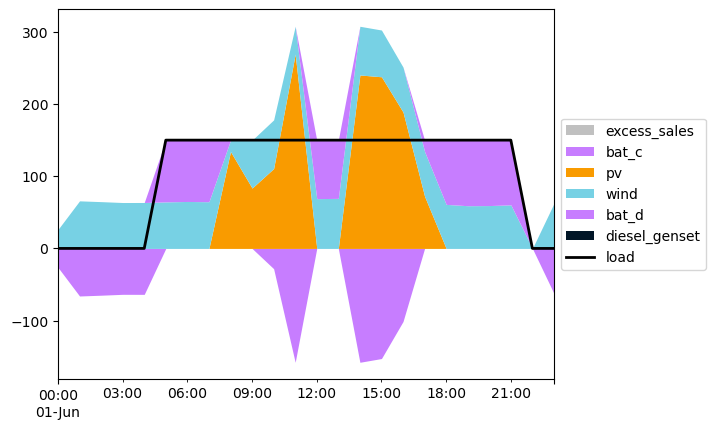

In [393]:
cm = {
    'wind':'#77D1E4',
    'pv':'#F99B00',
    'bat_c':'#C77DFF',
    'bat_d':'#C77DFF',
    "excess_sales": "silver",
    'load_shedding':'r',
    "diesel_genset": "#011627",
}

power = n.generators_t.p.mul(n.generators.sign)
power['bat_c'] = -n.storage_units_t.p_store
power['bat_d'] = n.storage_units_t.p_dispatch
power[power['bat_d']<0] =0 

plot_dates = pd.date_range('2024-06-01 00:00','2024-06-01 23:00',freq='H')
power = power.reindex(['excess_sales','bat_c','pv','wind','bat_d','diesel_genset'],axis=1)
power.loc[plot_dates].plot.area(stacked=True, lw=0, color=cm)
n.loads_t.p_set.loc[plot_dates].plot(ax=plt.gca(),color='k',lw=2)

#place legend outside right
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [389]:
stop

NameError: name 'stop' is not defined

# Adding a custom constraint

In [391]:
outage = n.snapshots[n.snapshots.hour.isin([12,13])]

lhs =  n.model.variables["Generator-p"].sel(Generator="pv", snapshot=outage)
rhs = 0
n.model.add_constraints(lhs, "<=", rhs, name="pv_outage")

Constraint `pv_outage` (snapshot: 730):
---------------------------------------
[2024-01-01 12:00:00]: +1 Generator-p[2024-01-01 12:00:00, pv] ≤ -0.0
[2024-01-01 13:00:00]: +1 Generator-p[2024-01-01 13:00:00, pv] ≤ -0.0
[2024-01-02 12:00:00]: +1 Generator-p[2024-01-02 12:00:00, pv] ≤ -0.0
[2024-01-02 13:00:00]: +1 Generator-p[2024-01-02 13:00:00, pv] ≤ -0.0
[2024-01-03 12:00:00]: +1 Generator-p[2024-01-03 12:00:00, pv] ≤ -0.0
[2024-01-03 13:00:00]: +1 Generator-p[2024-01-03 13:00:00, pv] ≤ -0.0
[2024-01-04 12:00:00]: +1 Generator-p[2024-01-04 12:00:00, pv] ≤ -0.0
		...
[2024-12-28 13:00:00]: +1 Generator-p[2024-12-28 13:00:00, pv] ≤ -0.0
[2024-12-29 12:00:00]: +1 Generator-p[2024-12-29 12:00:00, pv] ≤ -0.0
[2024-12-29 13:00:00]: +1 Generator-p[2024-12-29 13:00:00, pv] ≤ -0.0
[2024-12-30 12:00:00]: +1 Generator-p[2024-12-30 12:00:00, pv] ≤ -0.0
[2024-12-30 13:00:00]: +1 Generator-p[2024-12-30 13:00:00, pv] ≤ -0.0
[2024-12-31 12:00:00]: +1 Generator-p[2024-12-31 12:00:00, pv] ≤ -0.0
[202

In [395]:
n.model.constraints["Bus-nodal_balance"]

Constraint `Bus-nodal_balance` (snapshot: 8760, Bus: 1):
--------------------------------------------------------
[2024-01-01 00:00:00, grid]: +1 Generator-p[2024-01-01 00:00:00, wind] + 1 Generator-p[2024-01-01 00:00:00, pv] + 1 Generator-p[2024-01-01 00:00:00, diesel_genset] + 1 Generator-p[2024-01-01 00:00:00, load_shedding] + 1 StorageUnit-p_dispatch[2024-01-01 00:00:00, battery_4h] - 1 StorageUnit-p_store[2024-01-01 00:00:00, battery_4h] = 0.0
[2024-01-01 01:00:00, grid]: +1 Generator-p[2024-01-01 01:00:00, wind] + 1 Generator-p[2024-01-01 01:00:00, pv] + 1 Generator-p[2024-01-01 01:00:00, diesel_genset] + 1 Generator-p[2024-01-01 01:00:00, load_shedding] + 1 StorageUnit-p_dispatch[2024-01-01 01:00:00, battery_4h] - 1 StorageUnit-p_store[2024-01-01 01:00:00, battery_4h] = 0.0
[2024-01-01 02:00:00, grid]: +1 Generator-p[2024-01-01 02:00:00, wind] + 1 Generator-p[2024-01-01 02:00:00, pv] + 1 Generator-p[2024-01-01 02:00:00, diesel_genset] + 1 Generator-p[2024-01-01 02:00:00, load_sh

In [392]:
n.optimize.solve_model(solver_name='cbc')

INFO:linopy.model: Solve problem using Cbc solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 136.85it/s]
INFO:linopy.io: Writing time: 0.4s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61324 primals, 140894 duals
Objective: 1.66e+09
Solver model: not available
Solver message: Optimal - objective value 1660150382.74751067




Welcome to the CBC MILP Solver 
Version: 2.10.7 
Build Date: May 17 2023 

command line - cbc -printingOptions all -import /tmp/linopy-problem-yuy04rfk.lp -solve -solu /tmp/linopy-solve-4n3b88ko.sol (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 62363 (-78531) rows, 53607 (-7717) columns and 174679 (-84423) elements
Perturbing problem by 0.001% of 3.673356e+08 - largest nonzero change 0.13489772 ( 0.0007821715%) - largest zero change 0.13489723
0  Obj 0 Primal inf 1239081.7 (6205)
536  Obj 258.19793 Primal inf 1123574.7 (6539)
1072  Obj 380.47426 Primal inf 1106411.6 (6721)
1608  Obj 481.3438 Primal inf 1087059.8 (6928)
2144  Obj 570.55716 Primal inf 1061558.7 (7118)
2680  Obj 17100724 Primal inf 1031020.5 (7237)
3216  Obj 44100872 Primal inf 999072.58 (7330)
3752  Obj 89101050 Primal inf 970624.97 (7396)
4288  Obj 1.314012e+08 Primal inf 935297.14 (7424)
4824  Obj 2.1067991e+08 Primal inf 895307.1 (7435)
5360  Obj 2.5469004e+08 Primal inf 869691.37

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, pv_outage were not assigned to the network.


('ok', 'optimal')